In [71]:
from statsmodels.stats.weightstats import CompareMeans
from scipy.stats import fisher_exact, beta, binom
from scipy.stats import norm, uniform, expon, bernoulli
from random import random
import matplotlib.pyplot as plt
from math import lgamma, sqrt
import numpy as np
from collections import defaultdict
from itertools import cycle, chain, product
import multiprocessing as mp
import time

In [160]:
def choice(ps):
    return np.random.choice(len(ps), p=ps)

def simulate_abtest(funnels, N, timespent_params, force_equal=False):
    traffic_split = [x[1] for x in funnels]
    funnel_assignment = []
    counts = defaultdict(int)
    for i in range(N):
        which_funnel = choice(traffic_split)
        if force_equal:
            if counts[0] == N/2:
                which_funnel = 1
            elif counts[1] == N/2:
                which_funnel = 0
        funnel_assignment.append(which_funnel)
        timespent_params[i] += funnels[which_funnel][0]
        counts[which_funnel] += 1
    return funnel_assignment

flatten = lambda l: [item for sublist in l for item in sublist]

def prepend(h, it):
    for i in it:
        yield h, i

def take(li, k):
    return [i[k] for i in li]

def mp_map(mapfn, it, thread_count=None):
    if thread_count is None:
        thread_count = mp.cpu_count() - 6
    pool = mp.Pool(thread_count)
    results = pool.map(mapfn, it)
    pool.close()
    return results

def make_images(timespent_params, timespents):
    N = len(timespents)
    width = int(sqrt(N))
    img_timespent_params = np.zeros((width, width))
    img_timespents = np.zeros((width, width))
    for x, y in product(range(width), range(width)):
        i = x * width + y
        img_timespent_params[x, y] = timespent_params[i]
        img_timespents[x, y] = timespents[i]
    return img_timespent_params, img_timespents

def make_images_aligned(timespent_params, timespents, funnel_assignment):
    N = len(timespents)
    width = int(sqrt(N))
    img_timespent_params = np.zeros((width, width))
    img_timespents = np.zeros((width, width))
    As = [i for i, which_funnel in enumerate(funnel_assignment) if which_funnel == 0]
    Bs = [i for i in range(N) if i not in As]
    for x, y in product(range(width), range(width)):
        i = x * width + y
        if i < len(As):
            img_timespent_params[x, y] = timespent_params[As[i]]
            img_timespents[x, y] = timespents[As[i]]
        else:
            img_timespent_params[x, y] = timespent_params[Bs[i - len(As)]]
            img_timespents[x, y] = timespents[Bs[i - len(As)]]
    return img_timespent_params, img_timespents
    
def draw_imgs(img_timespent_params, img_timespents):
    fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(20, 10))
    plt1.imshow(img_timespent_params, interpolation='nearest')
    plt1.set_xticks([])
    plt1.set_yticks([])
    plt2.imshow(img_timespents, interpolation='nearest')
    plt2.set_xticks([])
    plt2.set_yticks([])

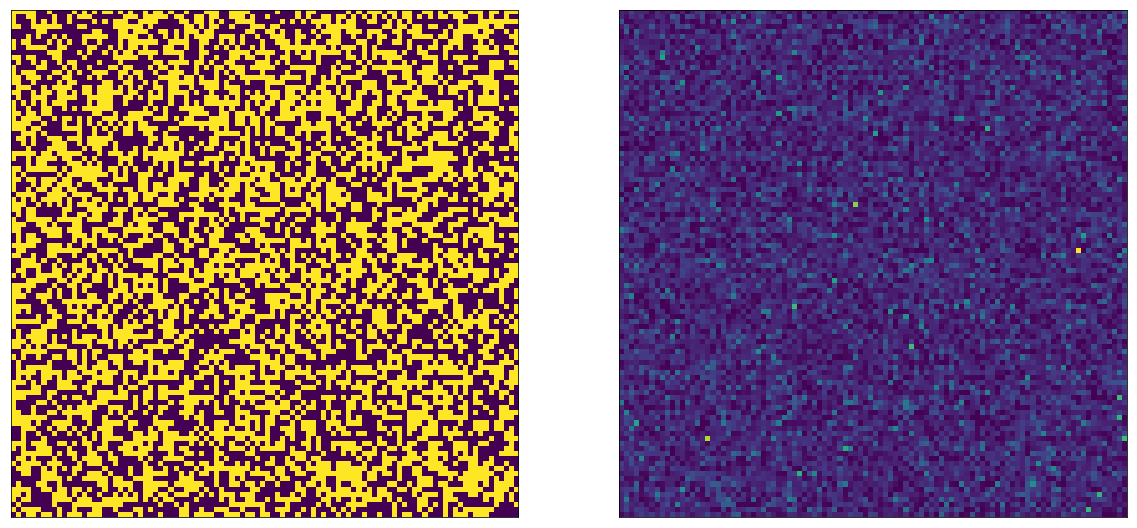

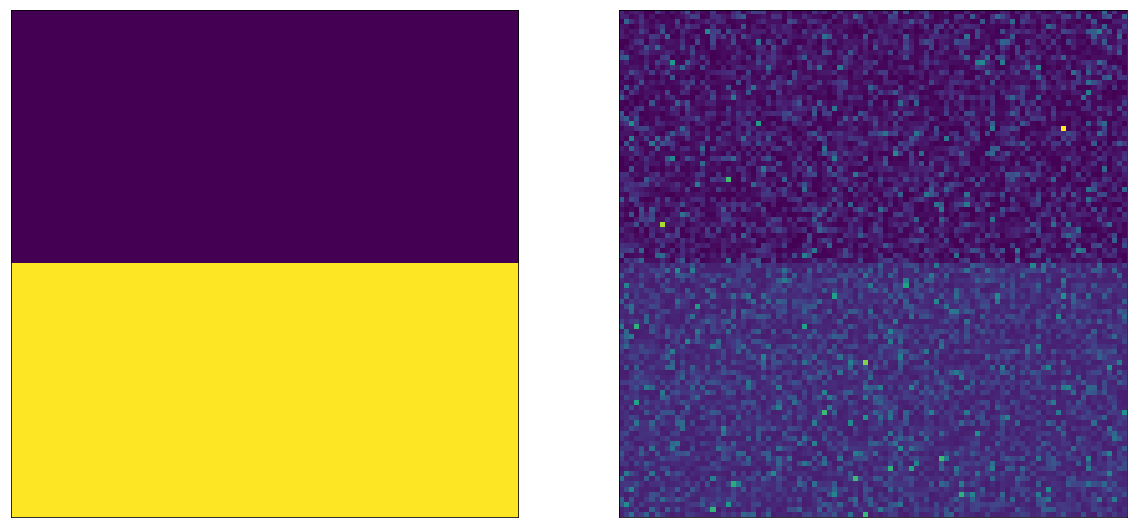

In [203]:
N=10*1000
funnels = [
    [0.00, 0.5],
    [1.00, 0.5],
]
timespent_params = defaultdict(lambda: 1.0)
timespents = {}

funnel_assignment = simulate_abtest(funnels, N, timespent_params, force_equal=True)

for i, param in timespent_params.items():
    timespents[i] = expon(param).rvs(size=1)[0]

draw_imgs(*make_images(timespent_params, timespents))
draw_imgs(*make_images_aligned(timespent_params, timespents, funnel_assignment))

test 0, experiment lift=1.0000, expected lift=1.0169, measured lift=1.0225, p-value=0.0000
test 1, experiment lift=2.0000, expected lift=2.0085, measured lift=1.9993, p-value=0.0000


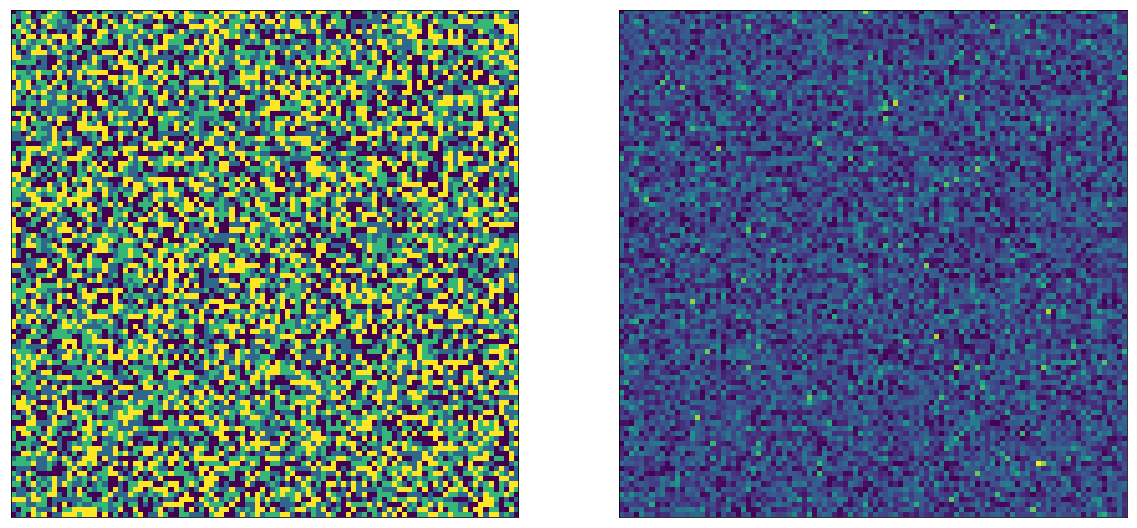

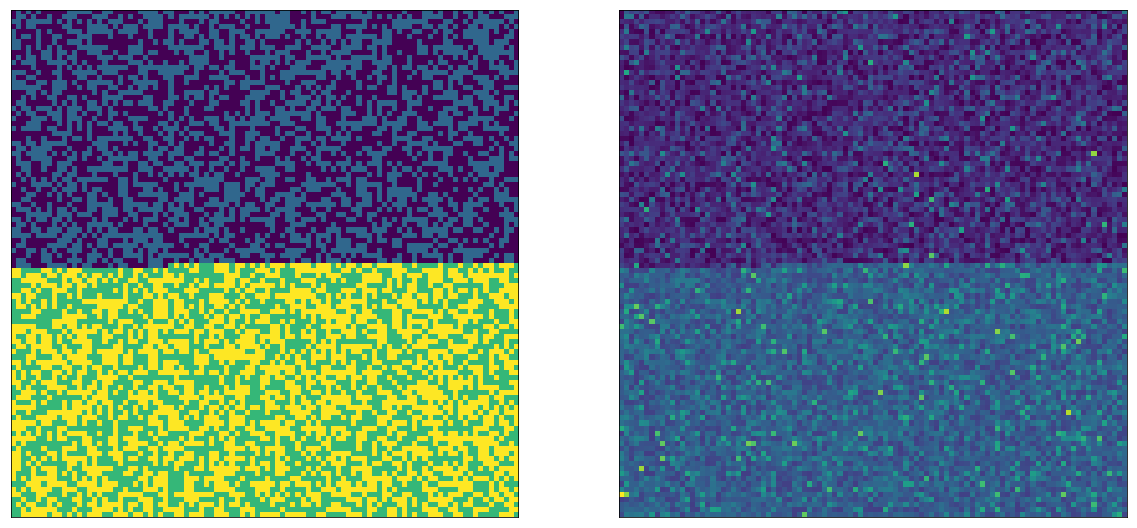

In [170]:
N = 10*1000
num_tests = 2
base_lift = 1
timespent_params = defaultdict(lambda: 1.0)
timespents = {}
funnel_assignments = []
for test in range(num_tests):
    funnels = [
        [0,                  0.5],
        [(test+1)*base_lift, 0.5],
    ]
    funnel_assignment = simulate_abtest(funnels, N, timespent_params)
    funnel_assignments.append(funnel_assignment)

for i, param in timespent_params.items():
    timespents[i] = expon(param).rvs(size=1)[0]
    
for test, funnel_assignment in enumerate(funnel_assignments):
    ps, ts = [[], []], [[], []]
    for i, which_funnel in enumerate(funnel_assignment):
        ts[which_funnel].append(timespents[i])
        ps[which_funnel].append(timespent_params[i])
    ps_means, ts_means = [np.mean(x) for x in ps], [np.mean(x) for x in ts]
    p = CompareMeans.from_data(ts[1], ts[0]).ztest_ind(alternative='larger', usevar='unequal')[1]
    print('test %d, experiment lift=%.4f, expected lift=%.4f, measured lift=%.4f, p-value=%.4f'
          % (test, (test+1)*base_lift, ps_means[1]-ps_means[0], ts_means[1]-ts_means[0], p))

draw_imgs(*make_images(timespent_params, timespents))
draw_imgs(*make_images_aligned(timespent_params, timespents, funnel_assignments[-1]))

test 0, experiment lift=0.0000, expected lift=0.0605, measured lift=0.0656, p-value=0.0101
test 1, experiment lift=0.1000, expected lift=0.1168, measured lift=0.1027, p-value=0.0001
test 2, experiment lift=0.2000, expected lift=0.2122, measured lift=0.1929, p-value=0.0000
test 3, experiment lift=0.3000, expected lift=0.3125, measured lift=0.3113, p-value=0.0000
test 4, experiment lift=0.4000, expected lift=0.4011, measured lift=0.4153, p-value=0.0000
test 5, experiment lift=0.5000, expected lift=0.5037, measured lift=0.5526, p-value=0.0000
test 6, experiment lift=0.6000, expected lift=0.6013, measured lift=0.5849, p-value=0.0000
test 7, experiment lift=0.7000, expected lift=0.6867, measured lift=0.6740, p-value=0.0000
test 8, experiment lift=0.8000, expected lift=0.8124, measured lift=0.8005, p-value=0.0000
test 9, experiment lift=0.9000, expected lift=0.8973, measured lift=0.8763, p-value=0.0000
test 10, experiment lift=1.0000, expected lift=1.0157, measured lift=1.0209, p-value=0.000

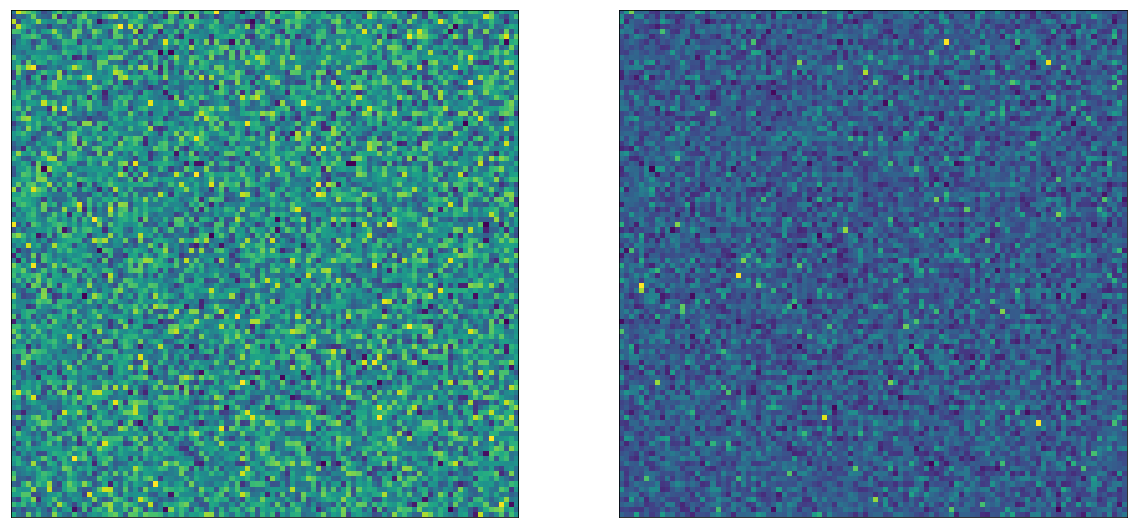

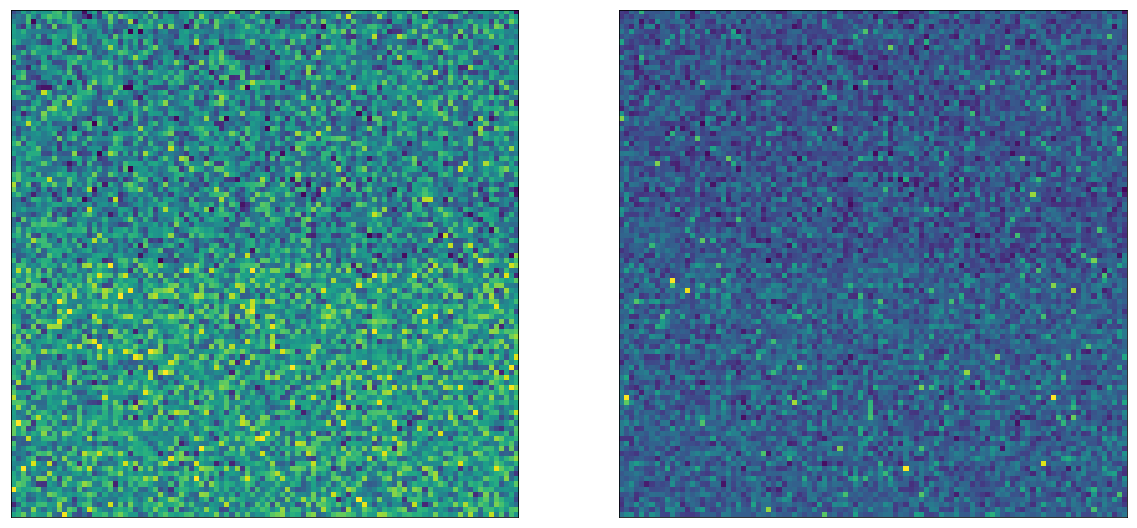

In [175]:
N = 10*1000
num_tests = 11
base_lift = 0.1
timespent_params = defaultdict(lambda: 1.0)
timespents = {}
funnel_assignments = []
for test in range(num_tests):
    funnels = [
        [0,                0.5],
        [test * base_lift, 0.5],
    ]
    funnel_assignment = simulate_abtest(funnels, N, timespent_params)
    funnel_assignments.append(funnel_assignment)

for i, param in timespent_params.items():
    timespents[i] = expon(param).rvs(size=1)[0]
    
for test, funnel_assignment in enumerate(funnel_assignments):
    ps, ts = [[], []], [[], []]
    for i, which_funnel in enumerate(funnel_assignment):
        ts[which_funnel].append(timespents[i])
        ps[which_funnel].append(timespent_params[i])
    ps_means, ts_means = [np.mean(x) for x in ps], [np.mean(x) for x in ts]
    p = CompareMeans.from_data(ts[1], ts[0]).ztest_ind(alternative='larger', usevar='unequal')[1]
    print('test %d, experiment lift=%.4f, expected lift=%.4f, measured lift=%.4f, p-value=%.4f'
          % (test, test*base_lift, ps_means[1]-ps_means[0], ts_means[1]-ts_means[0], p))

draw_imgs(*make_images(timespent_params, timespents))
draw_imgs(*make_images_aligned(timespent_params, timespents, funnel_assignments[5]))

In [3]:
# Ns=[10*1000, 100*1000, 1000*1000]
Ns=[10*1000, 20*1000, 30*1000, 40*1000, 50*1000, 100*1000, 200*1000, 1000*1000]
lifts = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.10]
num_simulations = 100

import parallel_ab_worker

results_list = []
if __name__ ==  '__main__':
    for N in Ns:
        print('Running simulations for N=%s...' % N)
        start_time = time.time()
        results = mp_map(
            parallel_ab_worker.mp_run_ab_test,
            [(N, lifts) for _ in range(num_simulations)])
        results_list.append(results)
        elapsed_time = time.time() - start_time
        print('Done! Elapsed %s' % time.strftime("%M:%S", time.gmtime(elapsed_time)))

results_map = defaultdict(list)
for result in flatten(flatten(results_list)):
    (N, lift, param_lift, actual_lift, p) = result
    results_map[(N, lift)].append((param_lift, actual_lift, p))

Running simulations for N=10000...
Done! Elapsed 00:44
Running simulations for N=20000...
Done! Elapsed 01:29
Running simulations for N=30000...
Done! Elapsed 02:14
Running simulations for N=40000...
Done! Elapsed 02:56
Running simulations for N=50000...
Done! Elapsed 03:39
Running simulations for N=100000...
Done! Elapsed 07:18
Running simulations for N=200000...
Done! Elapsed 14:29
Running simulations for N=1000000...
Done! Elapsed 10:02


In [8]:
for (N, lift) in results_map:
    param_lifts = take(results_map[(N, lift)], 0)
    actual_lifts = take(results_map[(N, lift)], 1)
    ps = take(results_map[(N, lift)], 2)
    print('N=%d lift=%.2f || param_lift_avg=%.3f, param_lift_stdev=%.3f actual_lift_avg=%.3f, actual_lift_stdev=%.3f p_avg=%.3f p_stdev=%.3f'
          % (N, lift, np.mean(param_lifts), np.std(param_lifts), np.mean(actual_lifts), np.std(actual_lifts), np.mean(ps), np.std(ps)))

N=10000 lift=0.00 || param_lift_avg=0.000, param_lift_stdev=0.001 actual_lift_avg=0.003, actual_lift_stdev=0.020 p_avg=0.467 p_stdev=0.290
N=10000 lift=0.01 || param_lift_avg=0.010, param_lift_stdev=0.001 actual_lift_avg=0.009, actual_lift_stdev=0.020 p_avg=0.379 p_stdev=0.272
N=10000 lift=0.02 || param_lift_avg=0.020, param_lift_stdev=0.001 actual_lift_avg=0.018, actual_lift_stdev=0.020 p_avg=0.264 p_stdev=0.230
N=10000 lift=0.03 || param_lift_avg=0.030, param_lift_stdev=0.001 actual_lift_avg=0.031, actual_lift_stdev=0.019 p_avg=0.129 p_stdev=0.194
N=10000 lift=0.04 || param_lift_avg=0.040, param_lift_stdev=0.001 actual_lift_avg=0.039, actual_lift_stdev=0.021 p_avg=0.086 p_stdev=0.127
N=10000 lift=0.05 || param_lift_avg=0.050, param_lift_stdev=0.001 actual_lift_avg=0.051, actual_lift_stdev=0.019 p_avg=0.031 p_stdev=0.062
N=10000 lift=0.10 || param_lift_avg=0.100, param_lift_stdev=0.001 actual_lift_avg=0.096, actual_lift_stdev=0.019 p_avg=0.000 p_stdev=0.000
N=20000 lift=0.00 || param_

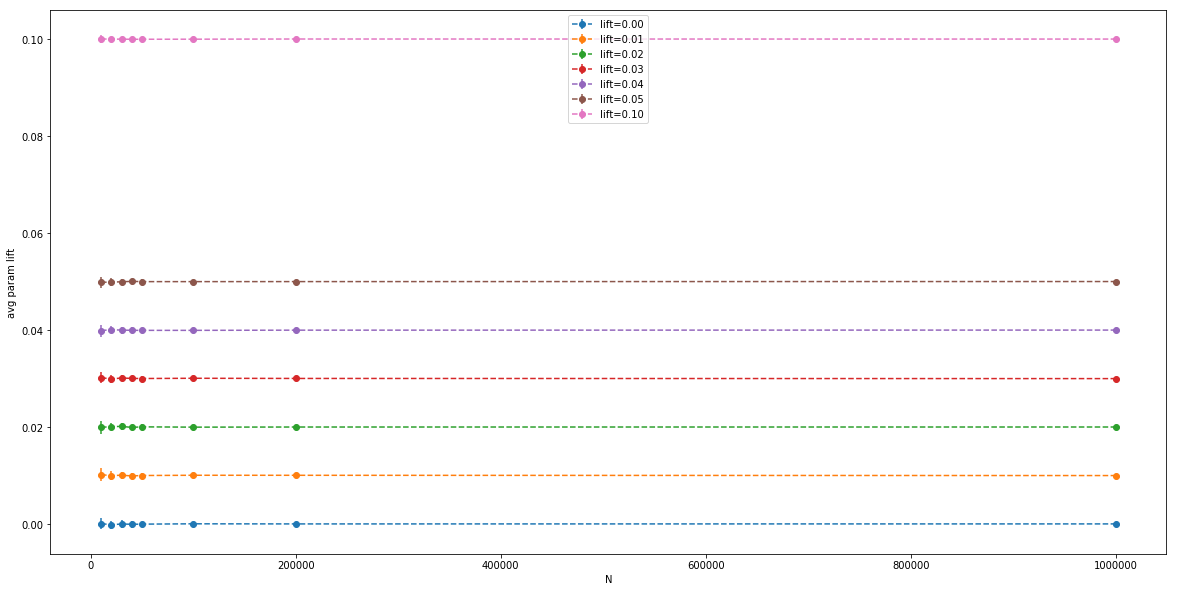

In [176]:
#shown_lifts = [0.00, 0.01, 0.05, 0.10]
shown_lifts = lifts
which = 0
def xs(lift): return Ns
def ys(lift): return [np.mean(take(results_map[(N, lift)], which)) for N in Ns]
def es(lift): return [np.std( take(results_map[(N, lift)], which)) for N in Ns]
plt.figure(figsize=(20,10))
plt.xlabel('N')
plt.ylabel('avg param lift')
for lift in shown_lifts:
    plt.errorbar(xs(lift), ys(lift), es(lift), marker='o', linestyle='--')
plt.legend([('lift=%.2f' % lift) for lift in shown_lifts], loc='upper center')
plt.show()

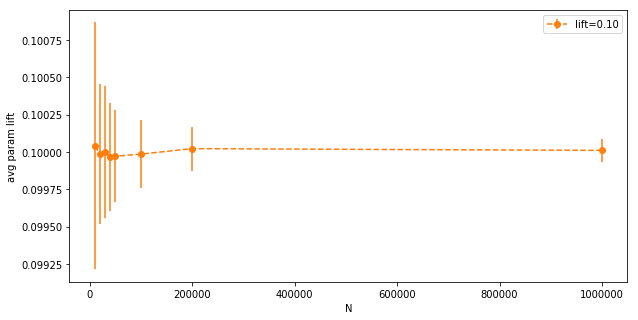

In [190]:
#shown_lifts = [0.00, 0.01, 0.05, 0.10]
shown_lifts = lifts
which = 0
def xs(lift): return Ns
def ys(lift): return [np.mean(take(results_map[(N, lift)], which)) for N in Ns]
def es(lift): return [np.std( take(results_map[(N, lift)], which)) for N in Ns]
plt.figure(figsize=(10, 5))
plt.xlabel('N')
plt.ylabel('avg param lift')
lift = 0.1
plt.errorbar(xs(lift), ys(lift), es(lift), marker='o', linestyle='--', color='#ff7f0e')
plt.legend(['lift=%.2f' % lift], loc='upper right')
plt.show()

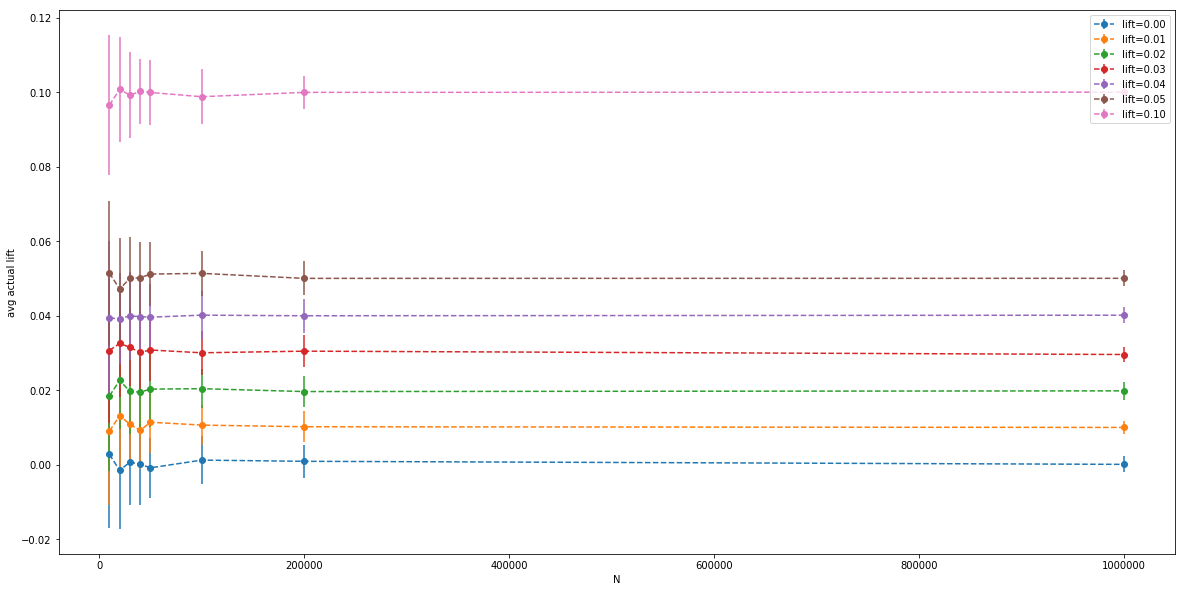

In [186]:
shown_lifts = lifts
which = 1
def xs(lift): return Ns
def ys(lift): return [np.mean(take(results_map[(N, lift)], which)) for N in Ns]
def es(lift): return [np.std( take(results_map[(N, lift)], which)) for N in Ns]
plt.figure(figsize=(20,10))
plt.xlabel('N')
plt.ylabel('avg actual lift')
for lift in shown_lifts:
    plt.errorbar(xs(lift), ys(lift), es(lift), marker='o', linestyle='--')
plt.legend([('lift=%.2f' % lift) for lift in shown_lifts], loc='upper right')
plt.show()

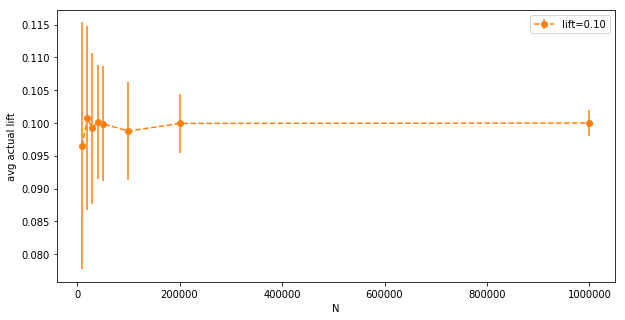

In [191]:
shown_lifts = lifts
which = 1
def xs(lift): return Ns
def ys(lift): return [np.mean(take(results_map[(N, lift)], which)) for N in Ns]
def es(lift): return [np.std( take(results_map[(N, lift)], which)) for N in Ns]
plt.figure(figsize=(10, 5))
plt.xlabel('N')
plt.ylabel('avg actual lift')
lift = 0.1
plt.errorbar(xs(lift), ys(lift), es(lift), marker='o', linestyle='--', color='#ff7f0e')
plt.legend(['lift=%.2f' % lift], loc='upper right')
plt.show()

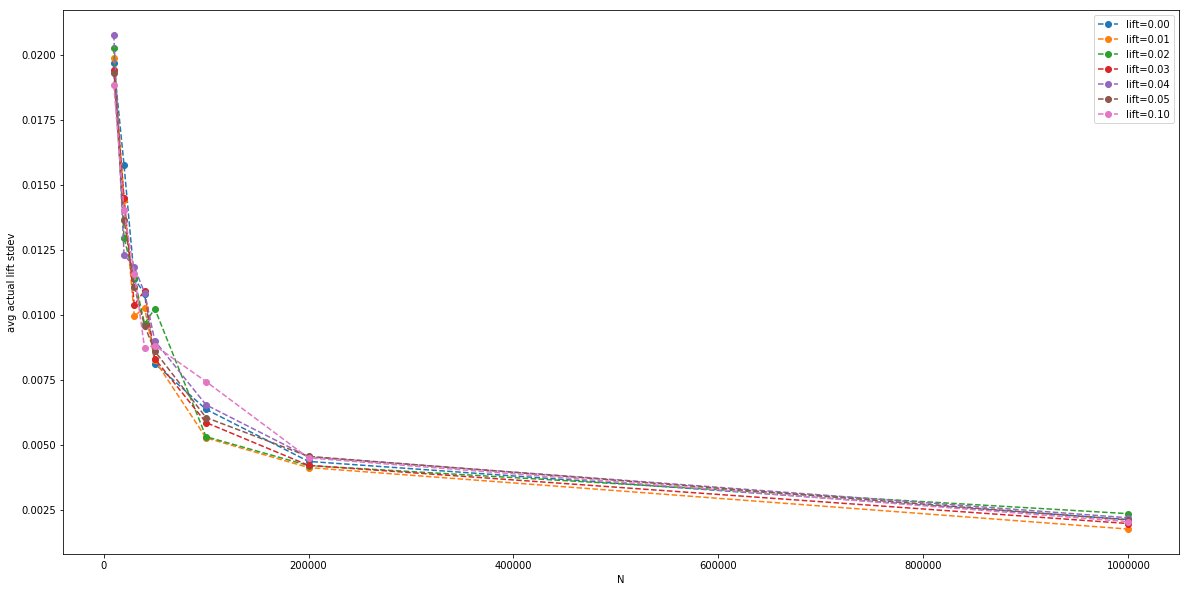

In [57]:
shown_lifts = lifts
which = 1
def xs(lift): return Ns
def es(lift): return [np.std( take(results_map[(N, lift)], which)) for N in Ns]
plt.figure(figsize=(20, 10))
plt.xlabel('N')
plt.ylabel('avg actual lift stdev')
for lift in shown_lifts:
    plt.plot(xs(lift), es(lift), marker='o', linestyle='--')
plt.legend([('lift=%.2f' % lift) for lift in shown_lifts], loc='upper right')
plt.show()

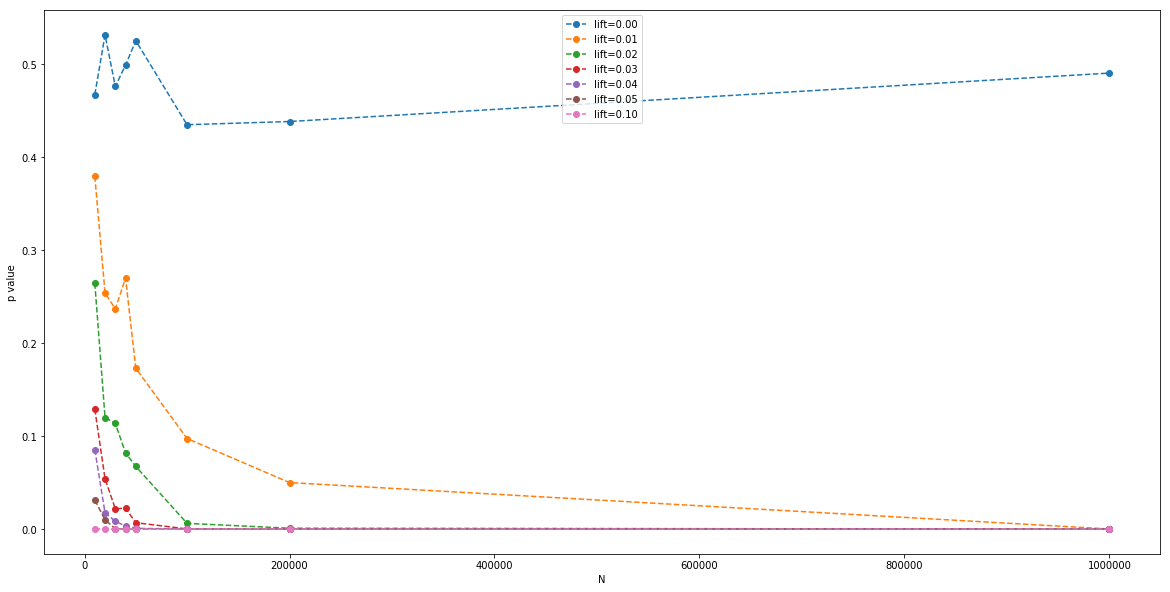

In [201]:
shown_lifts = lifts
which = 2
def xs(lift): return Ns
def ys(lift): return [np.mean(take(results_map[(N, lift)], which)) for N in Ns]
def es(lift): return [np.std( take(results_map[(N, lift)], which)) for N in Ns]
plt.figure(figsize=(20, 10))
plt.xlabel('N')
plt.ylabel('p value')
for lift in shown_lifts:
    plt.plot(xs(lift), ys(lift), marker='o', linestyle='--')
plt.legend([('lift=%.2f' % lift) for lift in shown_lifts], loc='upper center')
plt.show()

In [204]:
print('%02d' % 1)

01
